## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, compute the camera calibration using chessboard images

In [3]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')
prop_images = []

default_height, default_width = 720, 1280

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True and gray.shape == (default_height, default_width):
        objpoints.append(objp)
        imgpoints.append(corners)
        prop_images.append(img)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
#         cv2.imshow('img',img)
#         cv2.waitKey(500)
        
cv2.destroyAllWindows()

# Next, apply a distortion correction to the test images

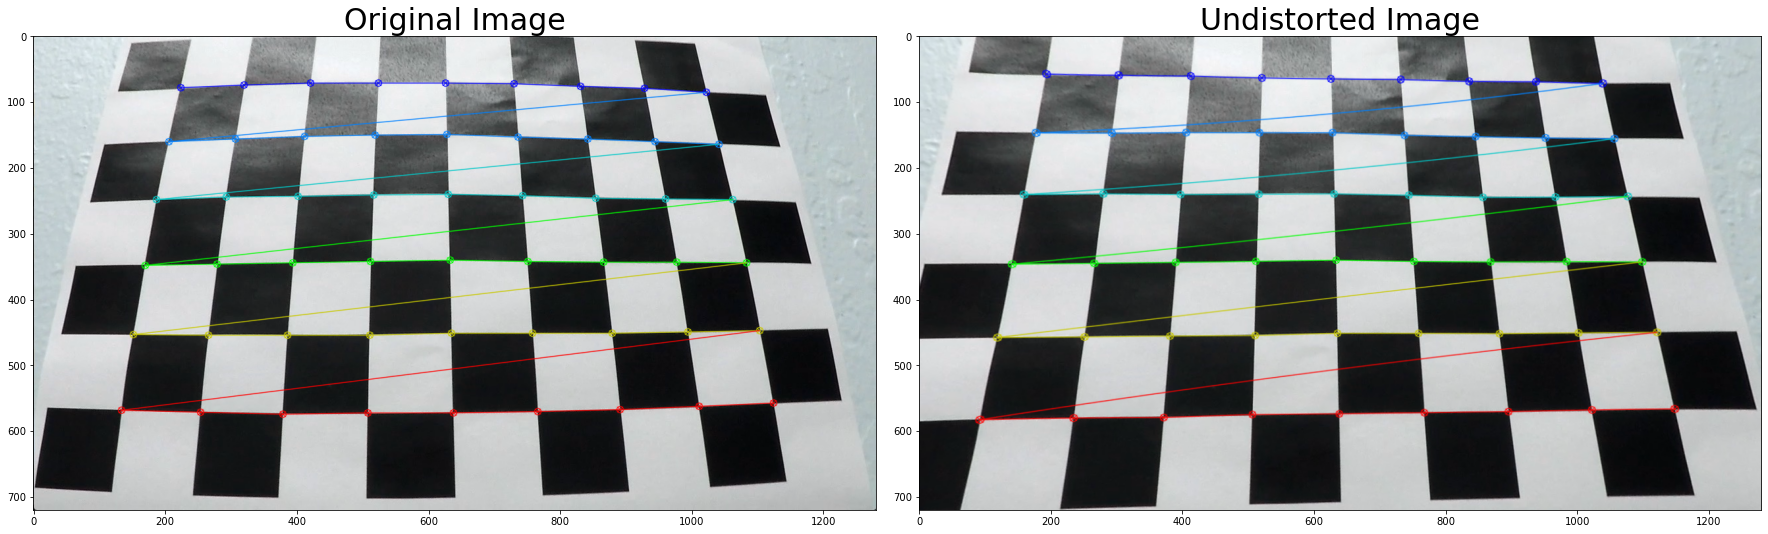

In [4]:
import random
%matplotlib inline

test_image_dist = random.choice(prop_images)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (default_width, default_height), None, None)
test_image_undist = cv2.undistort(test_image_dist, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_image_dist)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(test_image_undist)
ax2.set_title('Undistorted Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


# Test undistortion on a non-calibration image

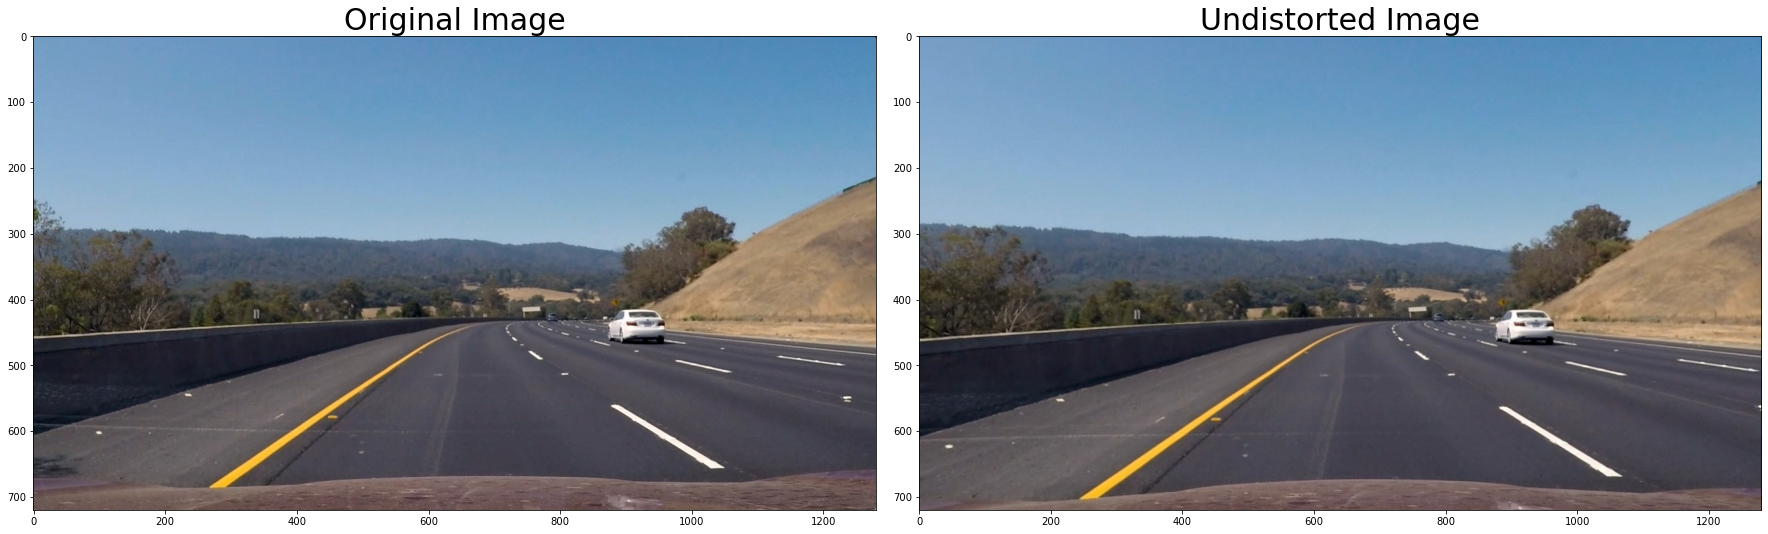

In [6]:
import matplotlib.image as mpimage

test_images = glob.glob('test_images/test*.jpg')
test_image_dist = mpimage.imread(random.choice(test_images))

assert test_image_dist.shape[:2] == (default_height, default_width)

test_image_undist = cv2.undistort(test_image_dist, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_image_dist)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(test_image_undist)
ax2.set_title('Undistorted Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Use color transforms and gradients to create a thresholded binary image

Text(0.5, 1.0, 'Saturation')

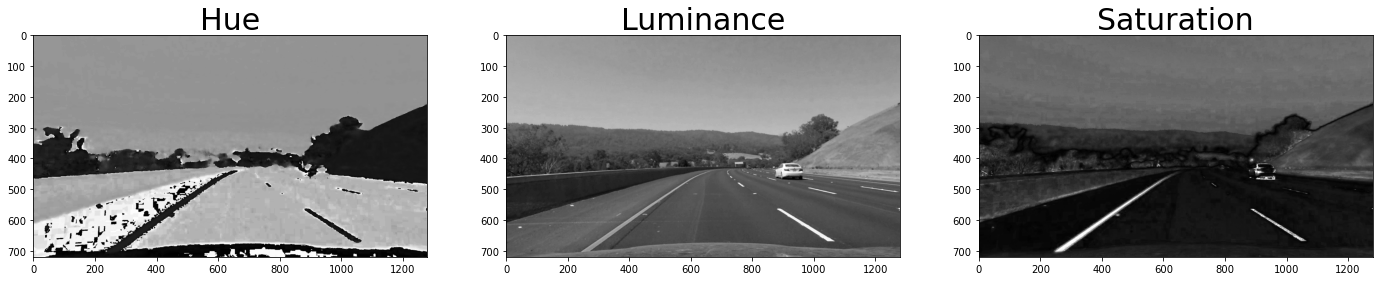

In [7]:
img = np.copy(test_image_undist)

img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
H = img_hls[:,:,0]
L = img_hls[:,:,1]
S = img_hls[:,:,2]

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
ax1.imshow(H, cmap='gray')
ax1.set_title('Hue', fontsize=30)
ax2.imshow(L, cmap='gray')
ax2.set_title('Luminance', fontsize=30)
ax3.imshow(S, cmap='gray')
ax3.set_title('Saturation', fontsize=30)

We see that saturation is best at picking up lane markings

# Compare different Sobel gradient thresholds on each channel + original image

Text(0.5, 1.0, 'Sobel Mag - Saturation')

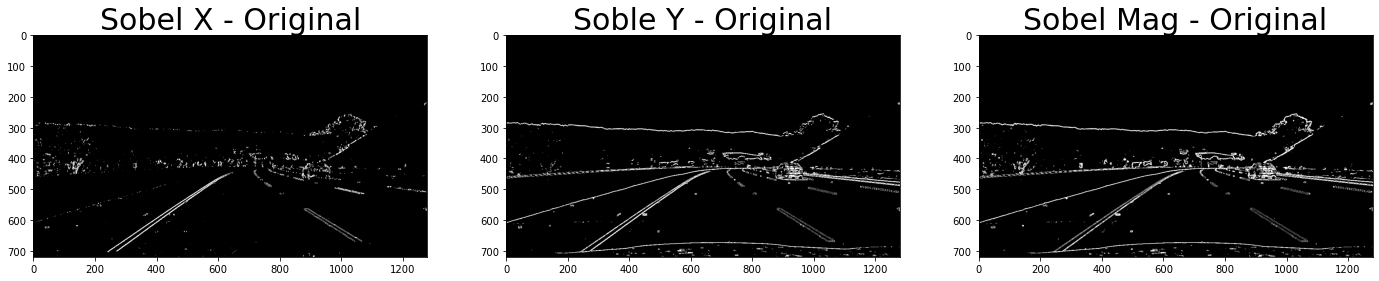

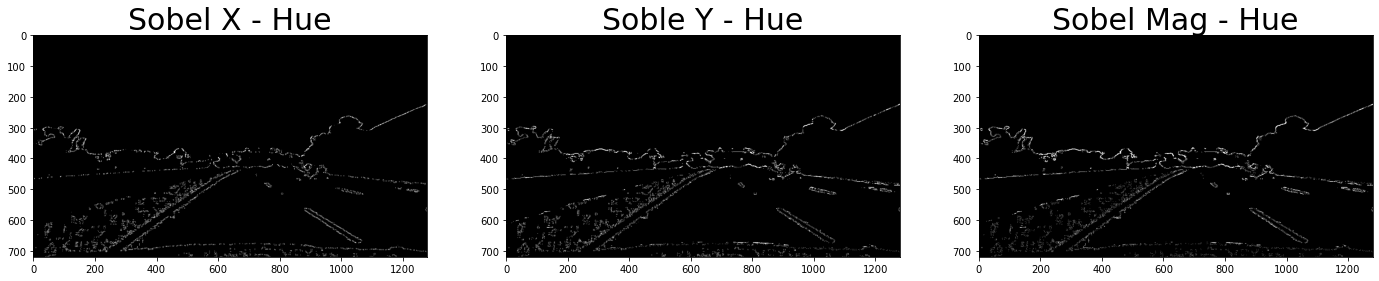

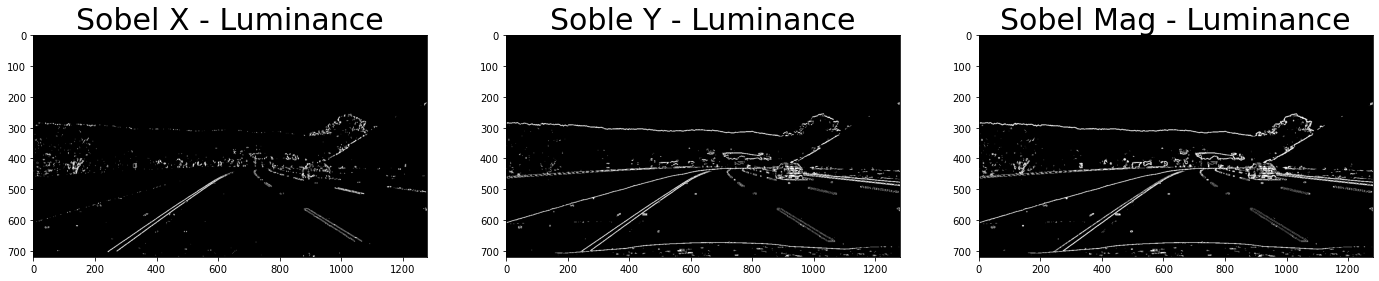

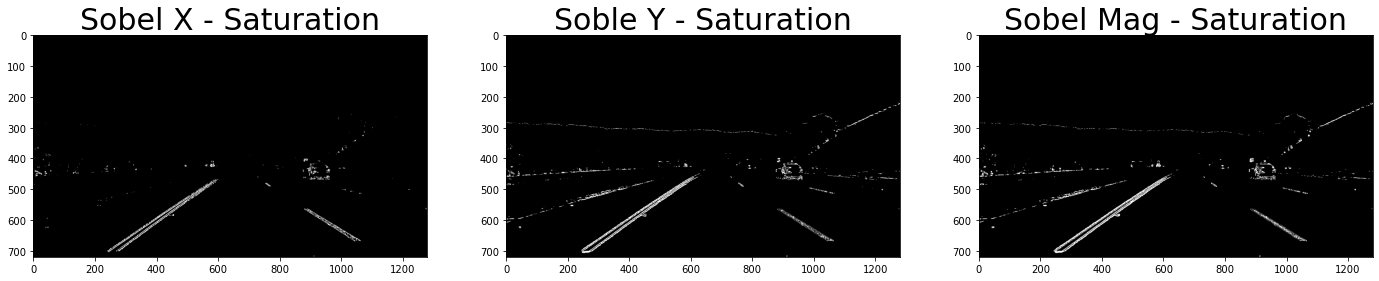

In [8]:
# applies Sobel x or y, then takes an absolute value and applies a threshold.
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    if len(img.shape) != 2:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = np.copy(img)
    sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0) if orient == 'x' else cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary_output

# applies Sobel x and y, then computes the magnitude of the gradient
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    if len(img.shape) != 2:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = np.copy(img)
    mag = np.sqrt(cv2.Sobel(gray, cv2.CV_64F, 1, 0)**2 + cv2.Sobel(gray, cv2.CV_64F, 0, 1)**2)
    scaled_sobel = np.uint8(255*mag/np.max(mag))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return binary_output

thresh_min, thresh_max = 30, 100

gray_img_sobelx = abs_sobel_thresh(img, orient='x', thresh_min=thresh_min, thresh_max=thresh_max)
gray_img_sobely = abs_sobel_thresh(img, orient='y', thresh_min=thresh_min, thresh_max=thresh_max)
gray_img_sobelmag = mag_thresh(img, mag_thresh=(thresh_min, thresh_max))
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
ax1.imshow(gray_img_sobelx, cmap="gray")
ax1.set_title('Sobel X - Original', fontsize=30)
ax2.imshow(gray_img_sobely, cmap="gray")
ax2.set_title('Soble Y - Original', fontsize=30)
ax3.imshow(gray_img_sobelmag, cmap="gray")
ax3.set_title('Sobel Mag - Original', fontsize=30)

gray_img_sobelx = abs_sobel_thresh(H, orient='x', thresh_min=thresh_min, thresh_max=thresh_max)
gray_img_sobely = abs_sobel_thresh(H, orient='y', thresh_min=thresh_min, thresh_max=thresh_max)
gray_img_sobelmag = mag_thresh(H, mag_thresh=(thresh_min, thresh_max))
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
ax1.imshow(gray_img_sobelx, cmap="gray")
ax1.set_title('Sobel X - Hue', fontsize=30)
ax2.imshow(gray_img_sobely, cmap="gray")
ax2.set_title('Soble Y - Hue', fontsize=30)
ax3.imshow(gray_img_sobelmag, cmap="gray")
ax3.set_title('Sobel Mag - Hue', fontsize=30)

gray_img_sobelx = abs_sobel_thresh(L, orient='x', thresh_min=thresh_min, thresh_max=thresh_max)
gray_img_sobely = abs_sobel_thresh(L, orient='y', thresh_min=thresh_min, thresh_max=thresh_max)
gray_img_sobelmag = mag_thresh(L, mag_thresh=(thresh_min, thresh_max))
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
ax1.imshow(gray_img_sobelx, cmap="gray")
ax1.set_title('Sobel X - Luminance', fontsize=30)
ax2.imshow(gray_img_sobely, cmap="gray")
ax2.set_title('Soble Y - Luminance', fontsize=30)
ax3.imshow(gray_img_sobelmag, cmap="gray")
ax3.set_title('Sobel Mag - Luminance', fontsize=30)

gray_img_sobelx = abs_sobel_thresh(S, orient='x', thresh_min=thresh_min, thresh_max=thresh_max)
gray_img_sobely = abs_sobel_thresh(S, orient='y', thresh_min=thresh_min, thresh_max=thresh_max)
gray_img_sobelmag = mag_thresh(S, mag_thresh=(thresh_min, thresh_max))
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
ax1.imshow(gray_img_sobelx, cmap="gray")
ax1.set_title('Sobel X - Saturation', fontsize=30)
ax2.imshow(gray_img_sobely, cmap="gray")
ax2.set_title('Soble Y - Saturation', fontsize=30)
ax3.imshow(gray_img_sobelmag, cmap="gray")
ax3.set_title('Sobel Mag - Saturation', fontsize=30)


Maybe a combination of sobel X-gradient on the original grayscale image and sobel magitude-gradient on the saturation channel will work 

# Compare color thresholding on channels

Text(0.5, 1.0, 'Saturation binary')

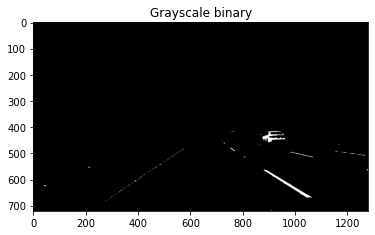

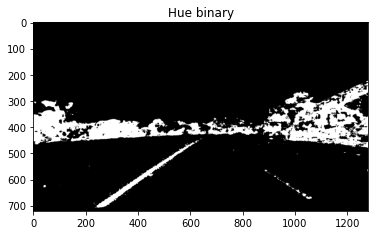

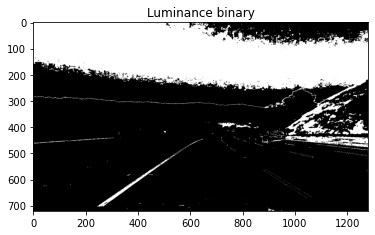

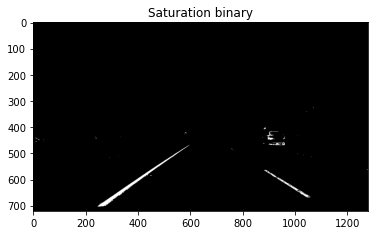

In [9]:
def binary_thresh(img, thresh_min=0, thresh_max=255):
    if len(img.shape) != 2:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = np.copy(img)
    binary = np.zeros_like(gray)
    binary[(gray > thresh_min) & (gray <= thresh_max)] = 1
    return binary

gray_binary = binary_thresh(img, thresh_min=200, thresh_max=255)
fig, ax = plt.subplots()
ax.imshow(gray_binary, cmap="gray")
ax.set_title("Grayscale binary")

hue_binary = binary_thresh(H, thresh_min=15, thresh_max=80)
fig, ax = plt.subplots()
ax.imshow(hue_binary, cmap="gray")
ax.set_title("Hue binary")

lumin_binary = binary_thresh(L, thresh_min=140, thresh_max=170)
fig, ax = plt.subplots()
ax.imshow(lumin_binary, cmap="gray")
ax.set_title("Luminance binary")

sat_binary = binary_thresh(S, thresh_min=150, thresh_max=255)
fig, ax = plt.subplots()
ax.imshow(sat_binary, cmap="gray")
ax.set_title("Saturation binary")

Looks like the final combination will be a composition of a binarized view of the saturation channel + sobel x-gradient on the originl grayscale + sobel magnitude on saturation channel

# Test thresholding part of lane-finding pipeline

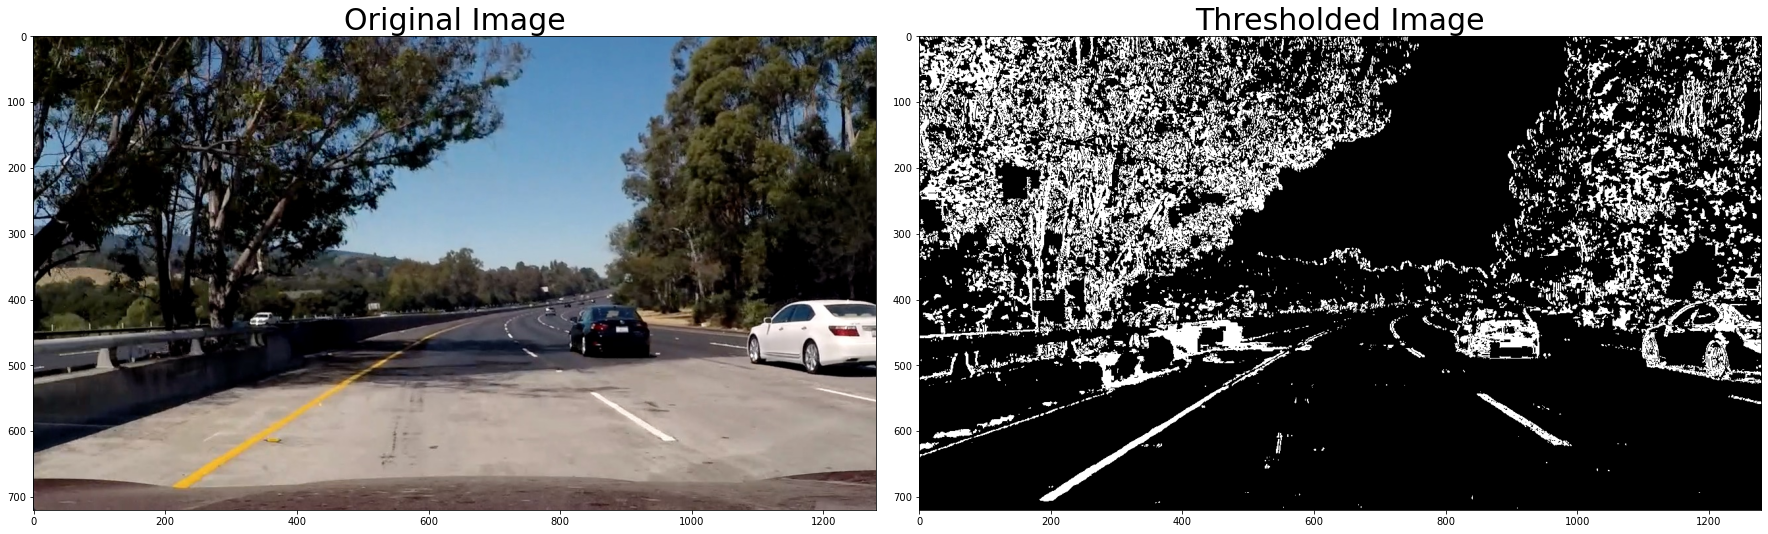

In [10]:
def test_thresholding_pipeline(raw_img):
    assert raw_img.shape[:2] == (default_height, default_width)
    img = cv2.undistort(raw_img, mtx, dist, None, mtx)
    gray_img_sobelx = abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=150)
    img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = img_hls[:,:,2]
    sat_binary = binary_thresh(S, thresh_min=160, thresh_max=255)
    gray_img_sobelmag = mag_thresh(S, sobel_kernel=9, mag_thresh=(125, 200))
    combined_binary = np.zeros_like(sat_binary)
    combined_binary[(gray_img_sobelx == 1) | (sat_binary == 1) | (gray_img_sobelmag == 1)] = 1
    return combined_binary

test_img = mpimage.imread(test_images[4])
    
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(test_thresholding_pipeline(test_img), cmap="gray")
ax2.set_title('Thresholded Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)